# Invisible recommendations

### Imports

In [1]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB


from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer


from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.metrics import explained_variance_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2_score
import sklearn.metrics as metrics
from sklearn import cross_validation, grid_search
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### Production

###### SQL

<code>SELECT
  o.id,                     # order id
  o.user_id,                # user id
  o.date,                   # order date
  o.date_end,               # fulfilment date
  o.status,                 # order status
  o.summ,                   # order amount
  o.first_order,            # is the first order
  iso.itemset_id,           # set id
  iso.quantity,             # quantity of this set
  iso.summ,                 # amount for this set
  ps.title,                 # set title
  ps.price,                 # set price
  ps.small_description,     # set short description
  ps.description_from_set,  # set long description
  ps.date,                  # set start of sales
  ps.successor_id,          # set successor
  au.date_joined,           # user joined
  au.date_activate          # user activated
FROM
  core_order AS o,
  core_itemset_order AS iso,
  core_partofset AS ps,
  auth_user au
WHERE
  o.id = iso.order_id AND
  ps.id = iso.itemset_id AND
  au.id = o.user_id
ORDER BY
  o.id
 </code>
successor — сеты-наследники, которые со временем изменялись. По идее они похожи. 
Также надо уделить внимание названиям. Часто люди останавливаются на сетах для новичков.

In [2]:
!gzip -dc ../input/orders_items_registrations.csv.gz > ../input/orders_items_registrations.csv
df = pd.read_csv('../input/orders_items_registrations.csv')
df.head(1)

order_id  user_id           order_date      fulfilment_date  orders_status  \
0        11       33  2012-12-11 10:21:22  2012-12-11 10:21:22              3   

   order_amount  is_the_first_order  set_id  quantiy_of_this_set  \
0          4600                   1       2                    1   

   amount_for_this_set  set_title  set_price              set_shirt_desc  \
0                 4600  Ящик вина       4900  3 красного и 3 белого вина   

  set_long_desc set_start_of_sales  set_successor          user_joined  \
0           NaN                NaN            NaN  2012-12-11 10:16:07   

        user_activated  
0  2012-12-11 10:16:07

## Data preprocessing

In [3]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['fulfilment_date'] = pd.to_datetime(df['fulfilment_date'])
df['user_joined'] = pd.to_datetime(df['user_joined'])
df['user_activated'] = pd.to_datetime(df['user_activated'])

## Data exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34490 entries, 0 to 34489
Data columns (total 18 columns):
order_id               34490 non-null int64
user_id                34490 non-null int64
order_date             34490 non-null datetime64[ns]
fulfilment_date        33172 non-null datetime64[ns]
orders_status          34490 non-null int64
order_amount           34490 non-null int64
is_the_first_order     34490 non-null int64
set_id                 34490 non-null int64
quantiy_of_this_set    34490 non-null int64
amount_for_this_set    34490 non-null int64
set_title              34490 non-null object
set_price              34490 non-null int64
set_shirt_desc         34490 non-null object
set_long_desc          26975 non-null object
set_start_of_sales     33942 non-null object
set_successor          13285 non-null float64
user_joined            34490 non-null datetime64[ns]
user_activated         34486 non-null datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(9), object(4

In [5]:
df.describe()

order_id       user_id  orders_status   order_amount  \
count  34490.000000  34490.000000   34490.000000   34490.000000   
mean   10769.975036  18651.013540       3.258104    8557.429719   
std     5899.526782  14326.886217       1.318843   14262.134078   
min       11.000000      1.000000       0.000000       1.000000   
25%     5685.000000   6618.000000       3.000000    4500.000000   
50%    10877.000000  14278.000000       3.000000    5001.000000   
75%    15723.750000  31784.500000       3.000000    9500.000000   
max    21141.000000  50170.000000      10.000000  297001.000000   

       is_the_first_order        set_id  quantiy_of_this_set  \
count        34490.000000  34490.000000         34490.000000   
mean             0.488026    270.409394             1.044158   
std              0.499864    132.187877             0.373828   
min              0.000000      2.000000             1.000000   
25%              0.000000    152.250000             1.000000   
50%              0.000000    287.000000             1.000000   
75%              1.000000    368.000000             1.000000   
max              1.000000    522.000000            17.000000   

       amount_for_this_set     set_price  set_successor  
count         34490.000000  34490.000000   13285.000000  
mean           4019.989272   3936.478631     433.141438  
std            3221.757431   2676.491556      44.421945  
min               0.000000      0.000000     360.000000  
25%            2000.000000   1500.000000     395.000000  
50%            4500.000000   4500.000000     427.000000  
75%            5000.000000   5000.000000     470.000000  
max          109200.000000  16500.000000     524.000000

In [6]:
#Check if column is categorical and has only one value
#or is empty and then drop columns without any valuable information
pd.set_option('display.max_rows',10)

type_count = {}
for column in df.columns:
    
    if df[column].dtype not in type_count:
        type_count[df[column].dtype] = 0
    else: 
        type_count[df[column].dtype] += 1
        
    print '[%s]' % (df[column].dtype), df[column].name,  df[column].describe()
    categories_count = len(df[column].value_counts())
    print '\nWith %s unique values: \n' %(categories_count)

    if categories_count < pd.get_option('display.max_rows'):
        for value_name in df[column].value_counts().index:
            print value_name, df[column].value_counts()[value_name], float(df[column].value_counts()[value_name])/len(df)*100
    else:
        print df[column].value_counts()


    print '\n'

[int64] order_id count    34490.000000
mean     10769.975036
std       5899.526782
min         11.000000
25%       5685.000000
50%      10877.000000
75%      15723.750000
max      21141.000000
Name: order_id, dtype: float64

With 20633 unique values: 

14969    61
1164      9
4474      9
11226     9
1441      8
         ..
19064     1
12919     1
625       1
2672      1
2049      1
Name: order_id, dtype: int64


[int64] user_id count    34490.000000
mean     18651.013540
std      14326.886217
min          1.000000
25%       6618.000000
50%      14278.000000
75%      31784.500000
max      50170.000000
Name: user_id, dtype: float64

With 8268 unique values: 

4798     69
9133     60
3341     59
2469     59
1293     58
         ..
13835     1
155       1
184       1
1169      1
749       1
Name: user_id, dtype: int64


[datetime64[ns]] order_date count                   34490
unique                  20621
top       2015-12-17 10:02:02
freq                       61
first     2012-12-11 10:

### Dates

In [7]:
time_btw_od_uj = df['order_date'] - df['user_joined']
time_btw_od_ua = df['order_date'] - df['user_activated']
time_btw_uj_ua = df['user_activated'] - df['user_joined'] 
print('---Time between Order Date and User Joined---')
print(time_btw_od_uj.describe())
print('---Time between Order Date and User Activated---')
print(time_btw_od_ua.describe())
print('---Time between User Activated and User Joined---')
print(time_btw_uj_ua.describe())

---Time between Order Date and User Joined---
count                       34490
mean     208 days 18:35:11.713395
std      243 days 23:47:20.104423
min               0 days 00:00:30
25%              16 days 23:39:48
50%             116 days 16:45:03
75%      320 days 15:10:45.500000
max            1238 days 04:42:13
dtype: object
---Time between Order Date and User Activated---
count                       34486
mean     201 days 19:34:00.114452
std      238 days 21:57:23.914496
min               0 days 00:00:29
25%       13 days 21:34:28.250000
50%             110 days 22:43:32
75%      311 days 05:32:21.500000
max            1238 days 04:42:13
dtype: object
---Time between User Activated and User Joined---
count                      34486
mean      6 days 23:28:01.147886
std      36 days 23:33:05.838003
min            -1 days +19:46:42
25%              0 days 00:00:00
50%              0 days 00:00:01
75%              2 days 02:51:08
max           1146 days 05:01:40
dtype: object


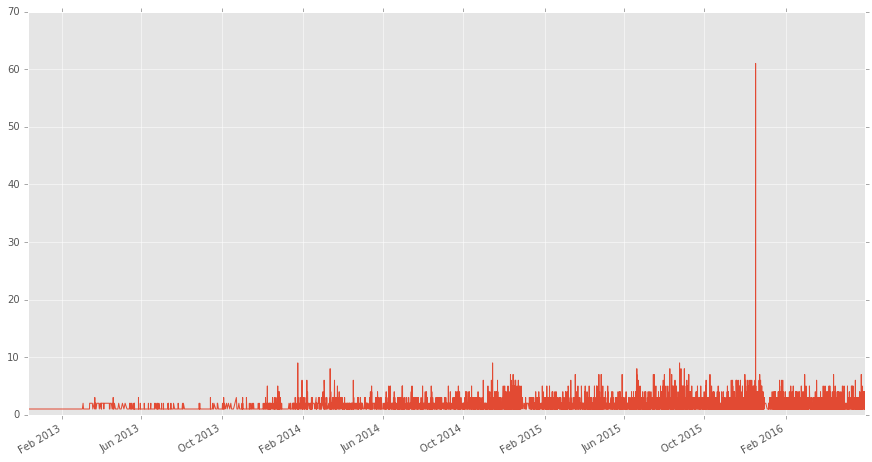

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
df['order_date'].value_counts().plot(kind='line', ax=axes)
fig.autofmt_xdate()
plt.show()

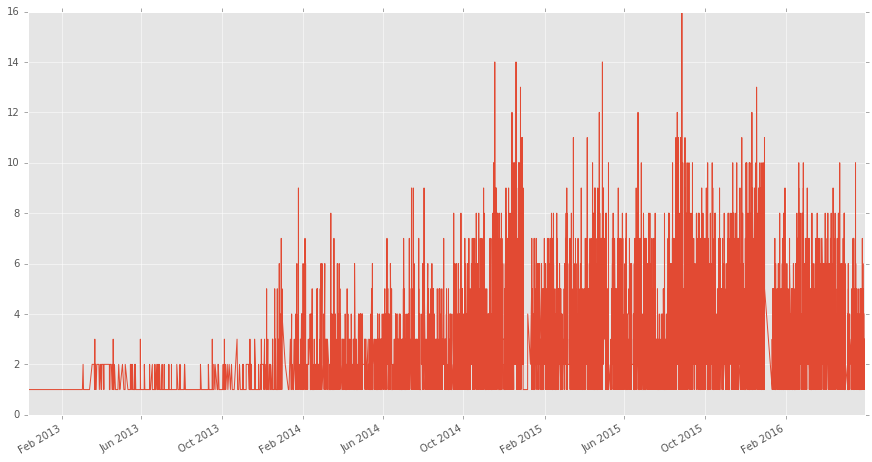

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
df['fulfilment_date'].value_counts().plot(kind='line', ax=axes)
fig.autofmt_xdate()
plt.show()

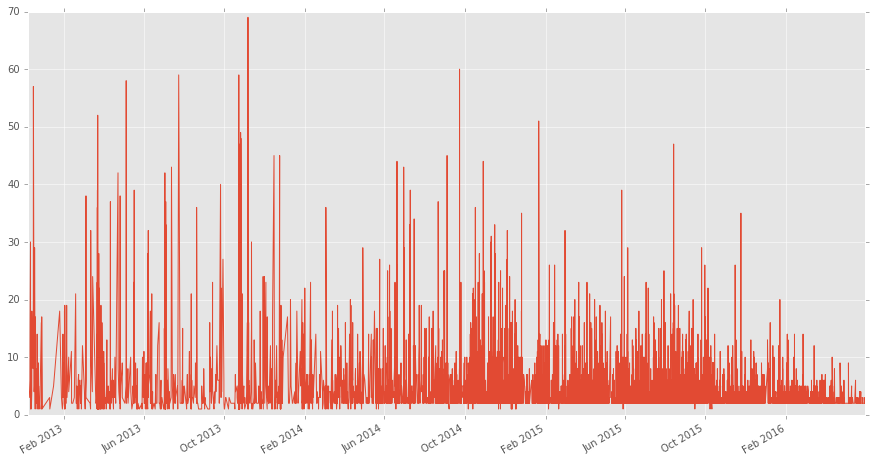

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
df['user_joined'].value_counts().plot(kind='line', ax=axes)
fig.autofmt_xdate()
plt.show()

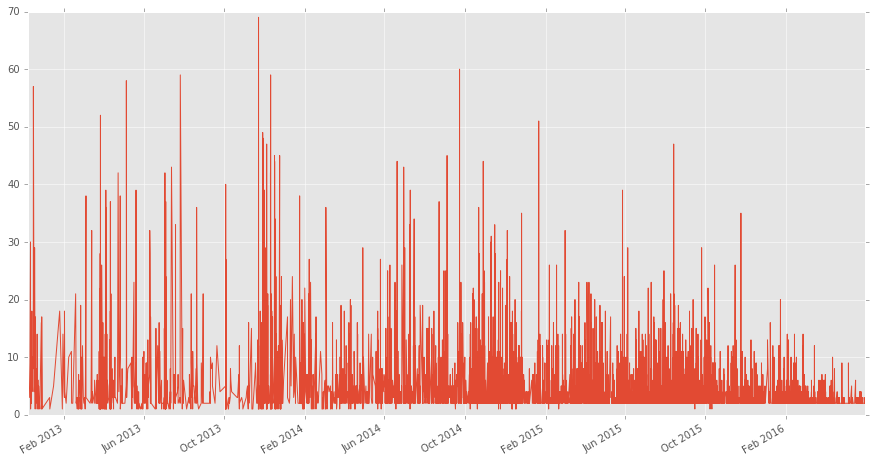

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
df['user_activated'].value_counts().plot(kind='line', ax=axes)
fig.autofmt_xdate()
plt.show()

In [21]:
import datetime as dt
df.order_date == dt.datetime(2015, 12, 31)

0        False
1        False
2        False
3        False
4        False
         ...  
34485    False
34486    False
34487    False
34488    False
34489    False
Name: order_date, dtype: bool

In [35]:
df['day'] = df['order_date'].dt.date
df['count'] = 1

In [36]:
df[df.order_date >= dt.datetime(2015, 12, 31)].groupby(['day'])['count'].agg(sum)

day
2016-01-01     2
2016-01-03     1
2016-01-05     5
2016-01-06     9
2016-01-07    10
              ..
2016-05-26    90
2016-05-27    46
2016-05-28    30
2016-05-29    19
2016-05-30    40
Name: count, dtype: int64

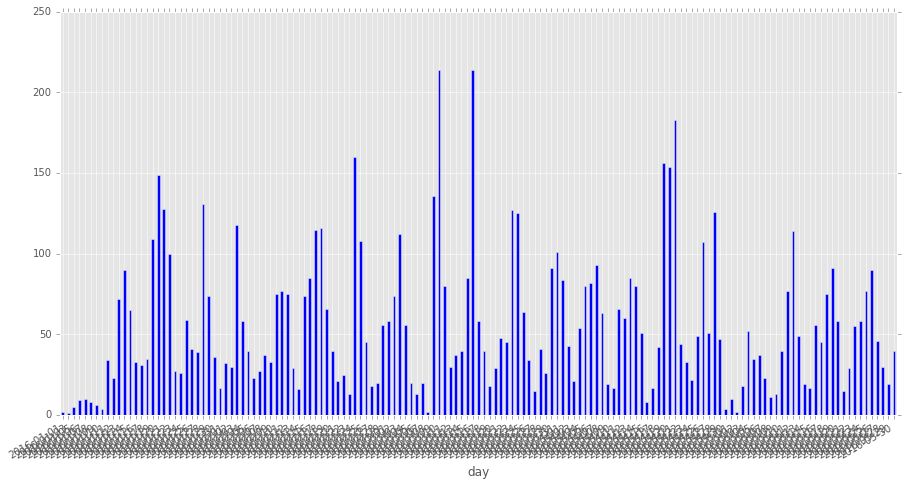

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
df[df.order_date >= dt.datetime(2015, 12, 31)].groupby(['day'])['count'].agg(sum).plot(kind='bar', ax=axes)
fig.autofmt_xdate()
plt.show()

### Сеты

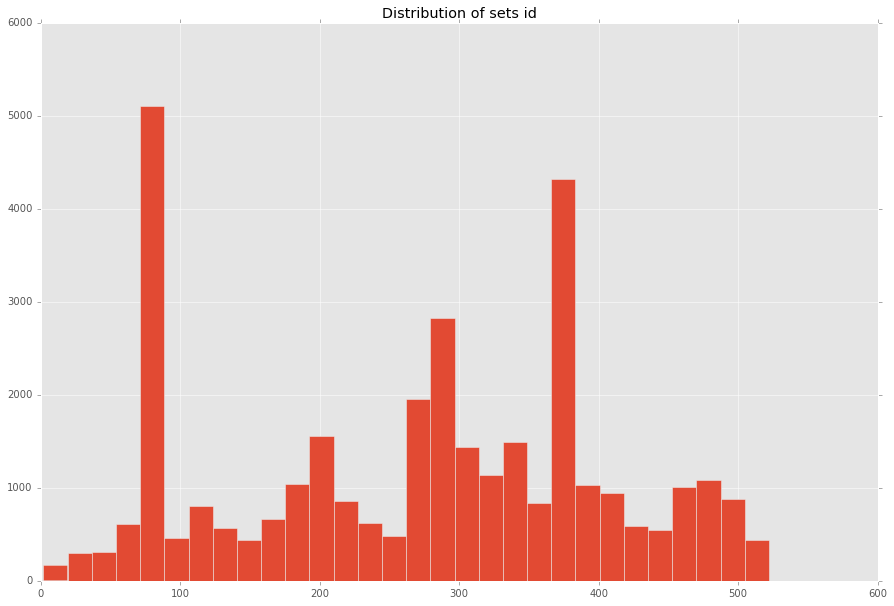

In [14]:
## distribution of sales variable
plt.figure(1,figsize=(15,10))
plt.hist(df.set_id,bins=30)
plt.title("Distribution of sets id")

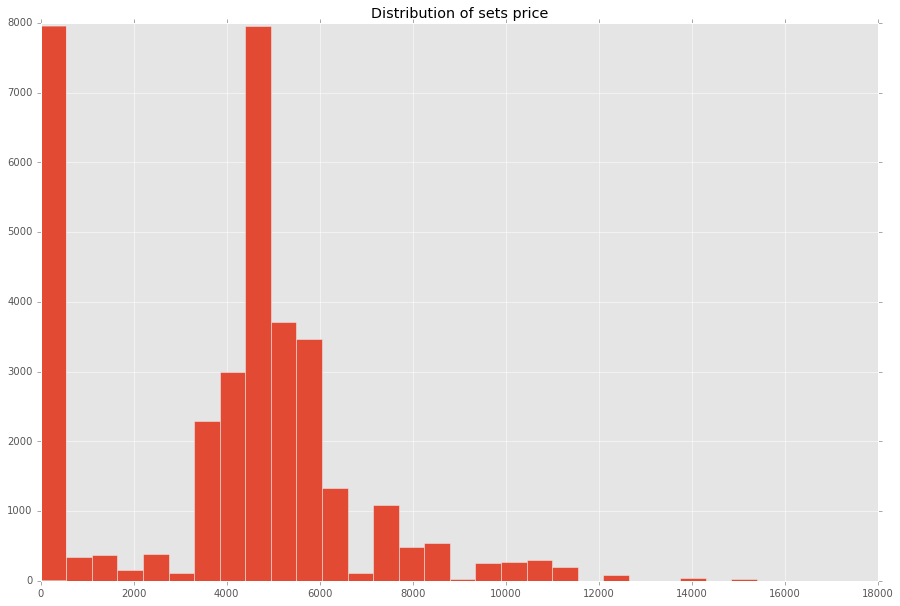

In [15]:
## distribution of sales variable
plt.figure(1,figsize=(15,10))
plt.hist(df.set_price,bins=30)
plt.title("Distribution of sets price")

## Постановка задачи

Цель: разработать систему рекомендации, чтобы понимать
<ul>
<li>
Какие сеты рекомендовать уже существующим пользователям
</li>
<li>
Какие сеты рекомендовать приходящим неактивированным пользователям
</li>
</ul>

Что читать:

<ol>
<li>
https://github.com/ocelma/python-recsys
</li>
<li>
https://www.quora.com/Are-there-any-good-implementations-of-regularized-svd-for-use-in-recommender-systems-in-python-If-not-why-not-Are-other-techniques-better
</li>
<li>
http://antoinevastel.github.io/machine%20learning/python/2016/02/14/svd-recommender-system.html
</li>
<li>
http://blogs.gartner.com/martin-kihn/how-to-build-a-recommender-system-in-python/
</li>
<li>
http://stats.stackexchange.com/questions/55797/svd-in-movie-recommendation
</li>
<li>
http://stats.stackexchange.com/questions/55797/svd-in-movie-recommendation
</li>
<li> * 
https://github.com/danielfrg/tsne
</li>
<li> *
https://lvdmaaten.github.io/tsne/
</li>
<li>
http://datareview.info/article/algoritm-t-sne-illyustrirovannyiy-vvodnyiy-kurs/
</li>

Дополнительно:


<ul>
<li>
https://github.com/Shayne13/Enron_Topic_Clustering с прицелом на парсинг описаний сетов (возможно я спарсю с сайта)
</li>
<li>
LDA 4 topic modelling
</li>
<li>
https://pypi.python.org/pypi/pysuggest/1.0
</li>
<li>
http://muricoca.github.io/crab/
</li>
<li>
https://github.com/Mendeley/mrec
</li>
</ul>


Что делать:

<ul>
<li>
Подчистить данные и написать выводы (убрать outliers)
</li>
<li>
Разбить выборку на тестовую и для обучения. В реальной жизни будут только будущие рекомендации, поэтому отсекать будем по месяцам. Например последние 4 месяца оставить для теста.
</li>
<li>
Когда будем уже рекомендовать, с другой стороны, можно будет использовать время года в качестве предиктора. Поэтому нужно будет добавить предикторы.
</li>

## Recommender system

### recsys

<code>
$ git clone git@github.com:ocelma/python-recsys.git
$ sudo python setup.py install
</code>

In [3]:
from recsys.algorithm.factorize import SVD
svd = SVD()

http://ocelma.net/software/python-recsys/build/html/examples.html